<a href="https://colab.research.google.com/github/msoley/CSCI-535/blob/main/Single_model_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#this is taken from [here](https://github.com/dssg/fairness_tutorial)
#data available [here](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data)
# Addressing Bias and Fairness in Machine Learning: A Practical Guide and Hands-on Tutorial
## KDD 2023 Hands-on Tutorial
### Rayid Ghani, Kit Rodolfa, Pedro Saleiro, Sérgio Jesus



# <font color=red>Auditing a Single Model using [Aequitas](http://www.datasciencepublicpolicy.org/projects/aequitas/)</font>
A more in-depth demo notebook is at https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb

### 1. Install dependencies, import packages and data
This is needed every time you open this notebook in colab to install dependencies

In [1]:
!pip install pandas==1.5.3
!pip install aequitas==0.42.0
!pip install fairlearn==0.4.6
!pip install hyperparameter-tuning
!pip install fairgbm==0.9.14
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import yaml
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
DATAPATH = 'https://github.com/dssg/fairness_tutorial/raw/master/data/'
DPI = 200


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.4/456.4 kB 39.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 5.2 MB/s eta 0:00:00
  Preparing 

## What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics.

As described earlier, the goal here is to select top 1000 project submissions that are likely to not get funded in order to prioritize resource allocation. That corresponds to the metric **Precision at top 1000**.


## Let's take a look at the performance of the models on one test set based on  **Precision at top 1000**

<ipython-input-2-448a7ab07b23>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(evals_df['model_precision'])


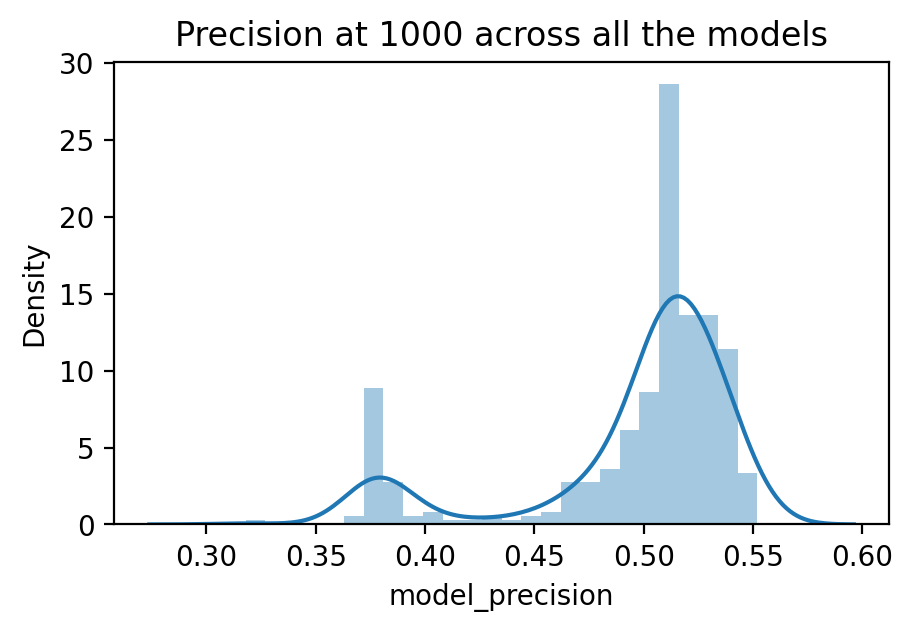

In [2]:
# code to load results and plot histogram with p@1000 for all models
evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')

ax = sns.distplot(evals_df['model_precision'])
ax.set_title('Precision at 1000 across all the models')
plt.gcf().set_size_inches((5, 3))
plt.gcf().set_dpi(DPI)
plt.show()

## We're now going to take the "best" model based on precision at top 1000 and audit its predicitons

# <font color=green>Auditing the Model with Highest Precision at top 1000</font>

### What do we need to audit the predictions?
1. predictions (scores or thresholded based on top 1000)
2. labels
3. attributes to audit (and a reference group within each attribute)
4. fairness metric(s)
5. disparity tolerance

## Load predictions, labels, and attributes to audit

In [3]:
# load pre-computed predictions, labels, attributes dataframe
df = pd.read_csv(DATAPATH + 'single_audit_df.csv.gz', compression='gzip')

Aequitas needs predictions (binary score), the label value, and the attributes to audit

In [4]:
# take a look at the dataframe we just loaded
df.head(10)

,score,label_value,poverty_level,metro_type,teacher_sex
0,0.0,0.0,lower,suburban_rural,female
1,0.0,0.0,highest,unknown,female
2,0.0,1.0,lower,suburban_rural,female
3,0.0,0.0,lower,unknown,female
4,0.0,0.0,lower,urban,female
5,0.0,1.0,lower,unknown,female
6,0.0,0.0,highest,urban,female
7,0.0,0.0,highest,unknown,female
8,0.0,1.0,lower,unknown,female
9,0.0,0.0,highest,unknown,female


In [5]:
# The score has been binarized (0/1) by taking the top 1000 highest scored predictions and calling them 1
# because we care about selecting the top 1000 projects)
df['score'].value_counts()

0.0    16677
1.0     1000
Name: score, dtype: int64

## Define Attributes to Audit and Reference Group for each Attribute

In [6]:
attributes_and_reference_groups={'poverty_level':'lower', 'metro_type':'suburban_rural', 'teacher_sex':'male'}
attributes_to_audit = list(attributes_and_reference_groups.keys())

## Select fairness metric(s) that we care about

In [7]:
metrics = ['tpr']

## Define  Disparity Tolerance

In [8]:
disparity_tolerance = 1.30

## Run Aequitas (based on the settings above)

In [9]:
# Initialize Aequitas
g = Group()
b = Bias()

# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(df, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict=attributes_and_reference_groups)

get_disparity_predefined_group()


## Look at Audit Results

Now we are going to focus our analysis on the fairness metric(s) of interest in this case study: TPR across different groups. The aequitas plot module exposes the disparities_metrics() plot, which displays both the disparities and the group-wise metric results side by side.

### Check for Fairness in Poverty Level

In [10]:
ap.disparity(bdf, metrics, 'poverty_level', fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [11]:
ap.absolute(bdf, metrics, 'poverty_level', fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

### Check for Fairness in Metro_Type (where the school is based)

In [12]:
ap.disparity(bdf, metrics, 'metro_type', fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [13]:
ap.absolute(bdf, metrics, 'metro_type', fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

### Check for Fairness in the Sex of the Teacher submitting the project